#### Procesamiento Digital de Señales

# Tarea Semanal 9

#### Por Nahuel Braian Contreras

Analizaremos la señal de ECG muestreado a $fs=1$ KHz durante una prueba de esfuerzo. A partir del mismo trataremos de definir los parametros de la plantilla para el cálculo del filtro pasabanda.

## Elección de plantilla
### Caso $fs_1$ y $fp_1$ 

Analizaremos la densidad de potencia de la señal de ECG

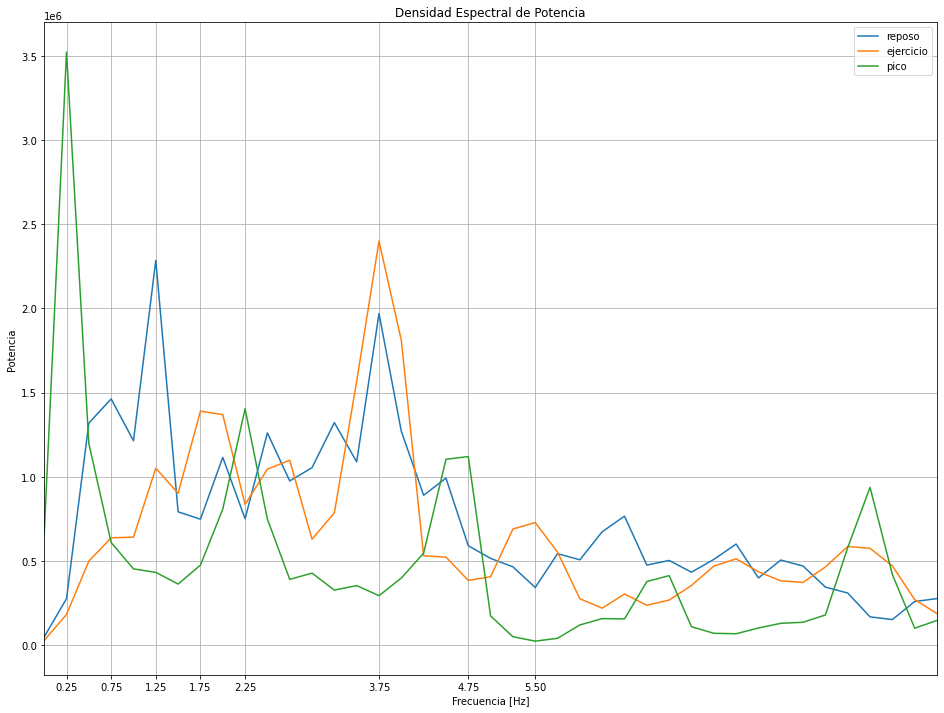

In [60]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import scipy.signal as sig

mat_struct = sio.loadmat('ECG_TP4.mat')

ecg_one_lead = mat_struct['ecg_lead']

fs = 1000
n = [100, 300, 760, 1000, 4000] #Elijo en n que me permita tener una buena resolución en la funcion Welch

#Analizando la señal de ECG podemos notar que el paciente en esta seccion estuvo en reposo
ECG_reposo = (ecg_one_lead[0:100000])
[f, PXX_pot_reposo] = sig.welch(ECG_reposo, fs = fs,nperseg = n[4], axis = 0)

#En esta sección los latido van reduciendo su período
ECG_reposo_ejercicio = (ecg_one_lead[450000:550000])
[f, PXX_pot_ejercicio] = sig.welch(ECG_reposo_ejercicio, fs = fs,nperseg = n[4], axis = 0)

#Los son los mas rapidos
ECG_peak = (ecg_one_lead[750000:850000])
[f, PXX_pot_peak] = sig.welch(ECG_peak, fs = fs,nperseg = n[4], axis = 0)

plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, (PXX_pot_reposo), label = 'reposo')
plt.plot(f, (PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, (PXX_pot_peak), label = 'pico')
plt.xlim([0,10])
plt.xticks([0.25,0.75,1.25,1.75,2.25,3.75,4.75,5.5])
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia")
plt.grid()
plt.legend()

Podemos notar varios picos de potencia para las diferentes secciones de la señal. Pero *¿A que corresponden estos picos en la señal de ECG?.* 

**Anlizemos un latido de la señal de ECG original para el caso Reposo**

Text(0, 0.5, 'Amplitud')

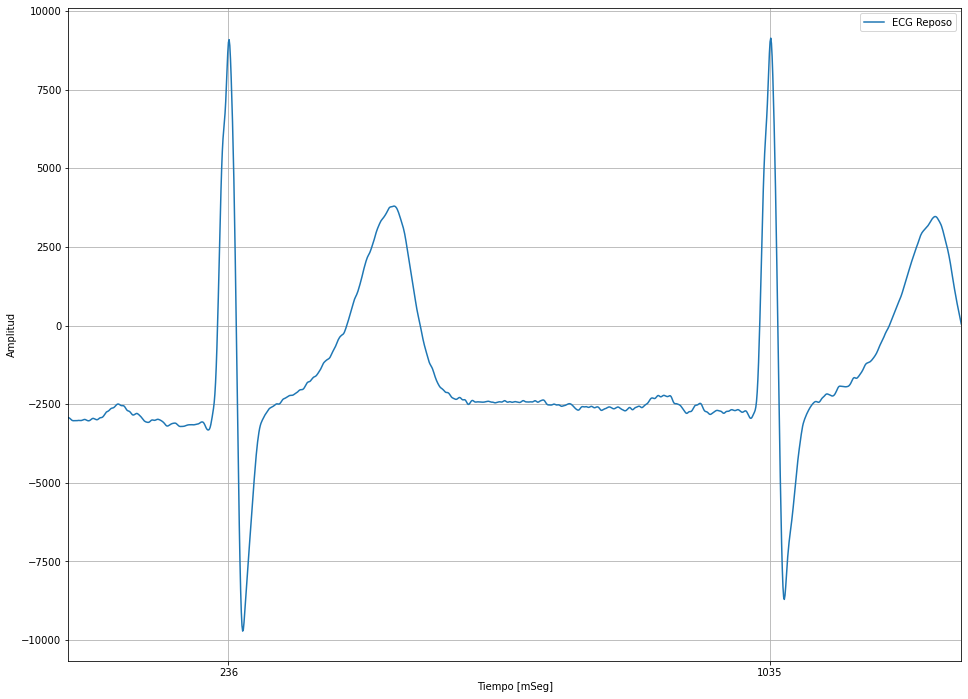

In [61]:
plt.gcf().set_size_inches(16, 12)
plt.plot(ECG_reposo[2527:3845], label = 'ECG Reposo')
plt.autoscale(enable=True, axis='x', tight=True)
plt.xticks([236,1035])
plt.grid()
plt.legend()
plt.xlabel('Tiempo [mSeg]')
plt.ylabel('Amplitud')

Si hacemos el calculo tenemos del periodo de esa señal tenemos que:

$$ f_{rep} = $\dfrac{1}{(1035 - 236)x10^{-3}} Hz$$

$$ f_{rep} \approx 1,25 Hz $$


Por lo tanto el primer pico en el grafico de la densidad de potencia corresponde al período de la señal de ECG en reposo, por lo tanto nos interesa **conservar esa informacion**. Los siguientes picos en los casos de ejercicio y pico tambien corresponden al periodo de su señal de ECG. Lo que ocurre es que los latidos son cada vez más rapido a medida que el esfuerzo del paciente se incrementa, lo que el período de cada latido disminuya, por lo que su energia se vera en una **frecuencia mas grande**
Por lo tanto definir como nuestra frecuencia de paso $fp_1$ en $0,75Hz$

Igualmente tenemos una gran cantidad de energia en una frecuencia lenta de $0,25Hz$. Esta energía no pertenece a la señal de ECG, por lo tanto **sera nuestra $fs_1$**

### Caso $fp_2$ 

A partir del analisis de la densidad espectral de potencia de la señal obtenido a traves del metodo de Welch definiremos hasta que frecuencia se encuentra el 99% de la potencia total de la ECG.

In [62]:
Proporcion = 0.99
Energia_acu = np.cumsum(PXX_pot_reposo)

index_Energia = np.where(np.cumsum(PXX_pot_reposo)/Energia_acu[-1] > Proporcion)[0]

W_corte = f[index_Energia[0]]
W_corte #Aprox 30

29.25

Haciendo el analisis, encontramos que desde 0 hasta la 29.25Hz tenemos el 99% de la potencia total de nuestra señal de ECG. Por lo tanto nuestra frecuencia de paso **$fp_2$ estará en $30Hz$**

### Caso $fs_2$ 

Para encontrar la segunda frecuencia de corte analizaremos el la densidad espectral de potencia en dB.

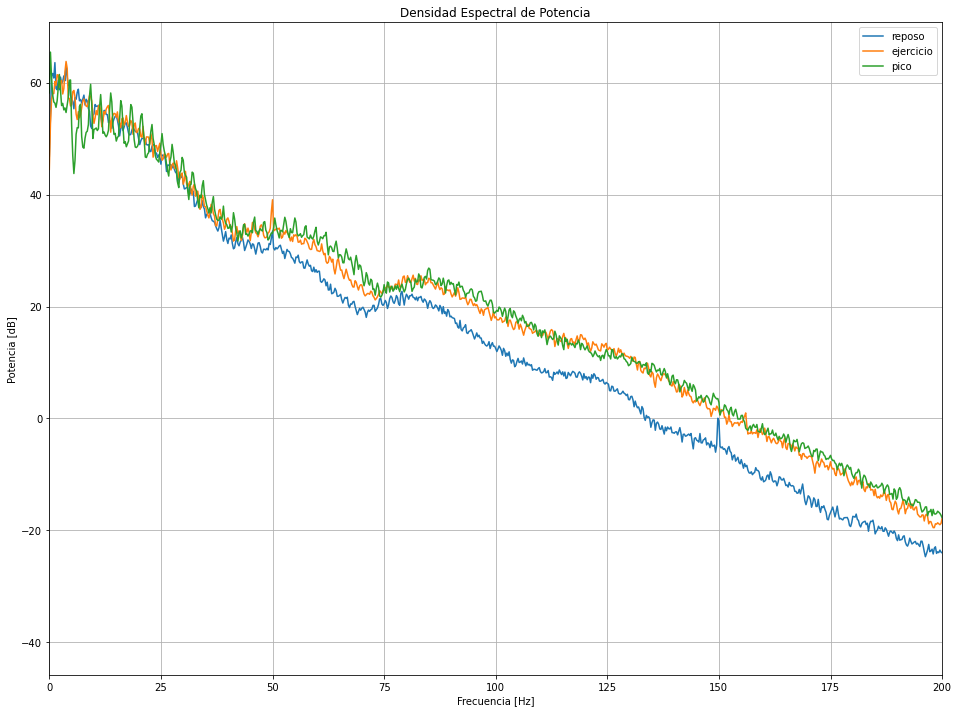

In [63]:
plt.gcf().set_size_inches(16, 12)
plt.title("Densidad Espectral de Potencia")
plt.plot(f, 10*np.log10(PXX_pot_reposo), label = 'reposo')
plt.plot(f, 10*np.log10(PXX_pot_ejercicio), label = 'ejercicio')
plt.plot(f, 10*np.log10(PXX_pot_peak), label = 'pico')
plt.xlabel("Frecuencia [Hz]")
plt.ylabel('Potencia [dB]')
plt.xlim([0,200])
plt.grid()
plt.legend()

Podemos apreciar que en la frecuencia de 50Hz se produce un pico de potencia. El siguiente visible se encuentra en 150Hz. Estos picos son producido por la red de linea. En nuestra pais, a la red electrica llegan 220V AC a 50Hz. Por lo tanto esta potencia visible no es parte de la ECG, por lo que podemos **elliminarla**

Nuestra frecuencia de corte **$fs_2$ estará en $50Hz$**

### Datos finales de la plantilla

$$fs_1 = 0.25Hz$$

$$fp_1 = 0.75Hz$$

$$fp_2 = 30Hz$$

$$fs_2 = 50Hz$$

## Analisis de latidos normales y ventriculares

Del archivo **ECG_TP4.mat** utilizaremos para este analisis el parametro:

qrs_pattern1: Complejo de ondas QRS normal

Dentro de el tendremos el momento en el cual se produce un pico en la señal de ECG expresado en mSeg. Haciendo un analisis de todos estos datos, podremos dividir cada señal individual de ECG producida en toda la medición. Asi podremos identificar la presencia de los latidos normales y los ventriculares, y utilizaremos algun método para poder distinguirlos y mostrar en limpio a cada uno

Text(0, 0.5, 'Amplitud')

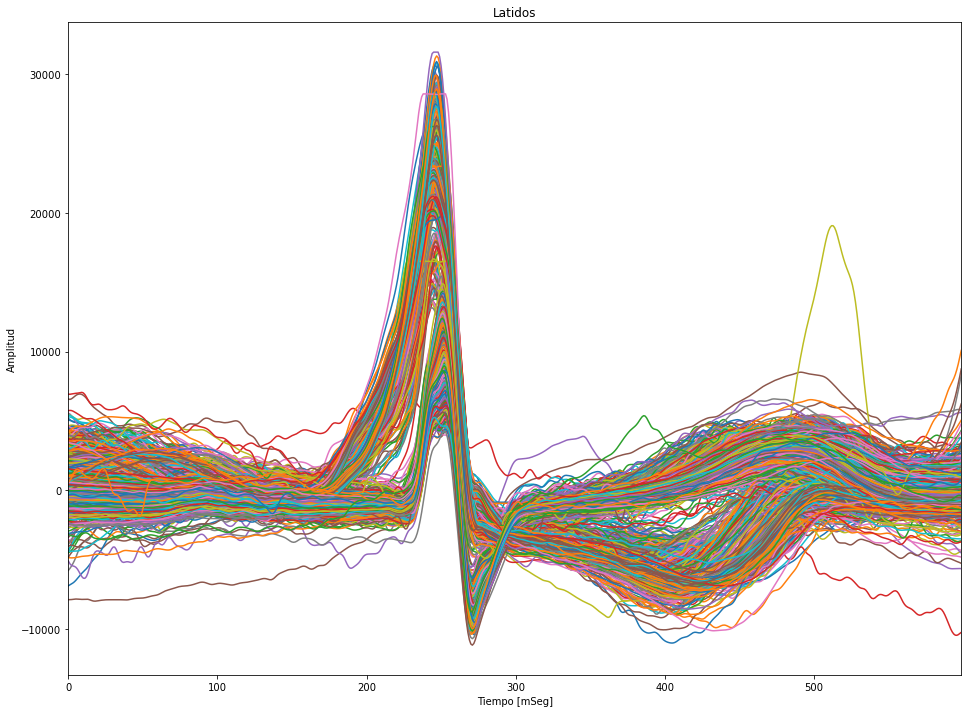

In [64]:
qrs_detections = mat_struct['qrs_detections']

# Viendo el grafico podemos ver que el latido va desde 0 a 600
# qsr me da el pico del latido que se encuentra en la primera muestra en 250
# por eso si me quiero quedar con toda la informacion desde el ecg selecciono desde
# (pico - 250) hasta (pico + 350)
inferior = 250
sup = 350

latido = (ecg_one_lead[int(qrs_detections[0] - inferior):int(qrs_detections[0] + sup)])
muestras = np.arange(len(qrs_detections))
latidos = np.zeros([sup+inferior, qrs_detections.shape[0]])

for nn in muestras:
    latidos[:,nn] = ecg_one_lead[int(qrs_detections[nn] - inferior):int(qrs_detections[nn] + sup)].flatten()
    latidos[:,nn]  -= np.mean(latidos[:,nn]) # le resto su valor medio para centrarlos


plt.gcf().set_size_inches(16, 12)
plt.plot(latidos)
plt.autoscale(enable=True, axis='x', tight=True)
plt.title("Latidos")
plt.xlabel('Tiempo [mSeg]')
plt.ylabel('Amplitud')

Aca podemos ver cada periodo de la señal superpuesta de ECG. Sin embargo tenemos que encontrar algun punto para poder diferenciar las normales, de las del tipo ventricular. Hagamos zoom en alguna sección

Text(0, 0.5, 'Amplitud')

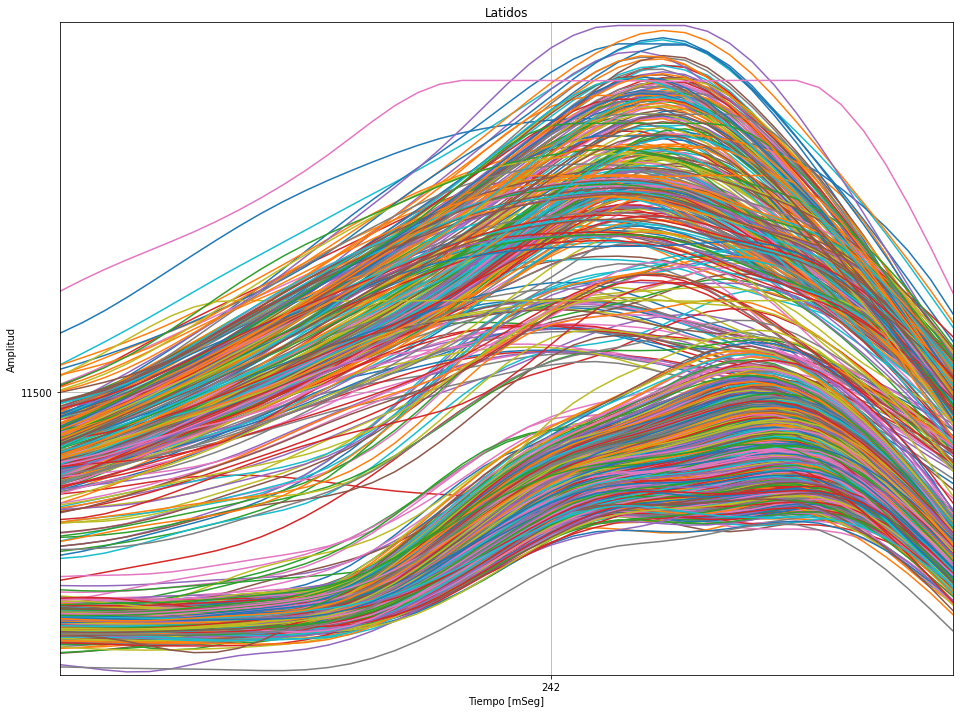

In [65]:
plt.gcf().set_size_inches(16, 12)
plt.plot(latidos)
plt.xlim([220, 260])
plt.ylim([-4000,31750])
plt.xticks([242])
plt.yticks([11500])
plt.grid()
plt.title("Latidos")
plt.xlabel('Tiempo [mSeg]')
plt.ylabel('Amplitud')

A partir de 242 milisegundos podemos notar la diferencia entre ambos tipos de señales. Desde 11500 para abajo tenemos a los **latidos normales**. En cambio desde 11500 para arriba tenemos a las señales del tipo **ventricular**. Procedemos a separar ambas señales

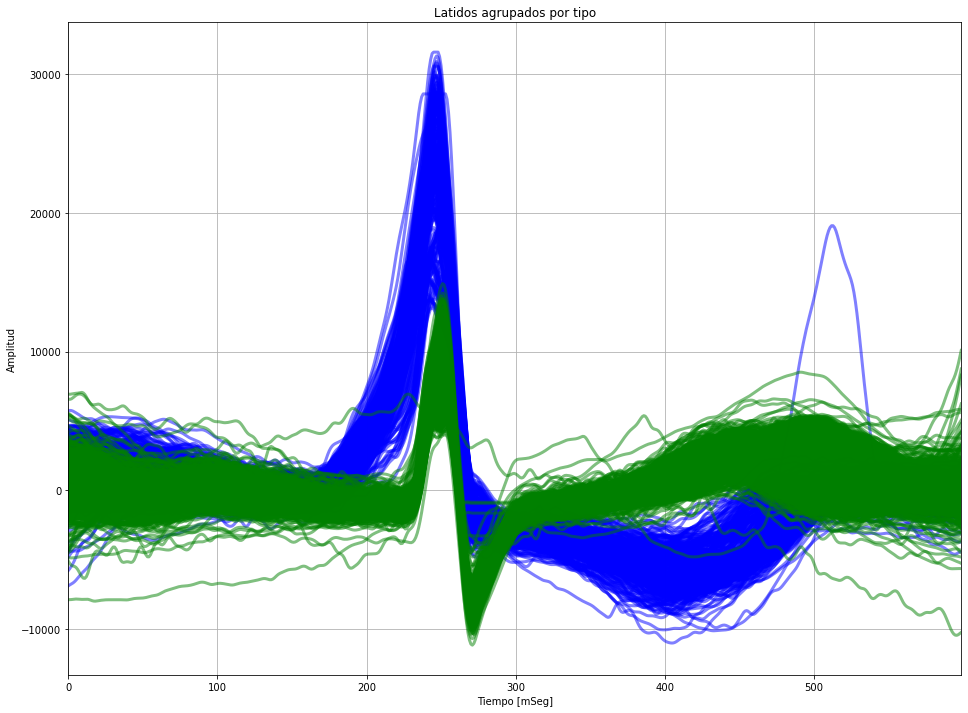

In [66]:
# Analizo la muestra de latidos para separar lo normales de los ventriculares
# veo que en la muestra 242 puedo distinguir bien ambos casos
Estimador_amplitud = latidos[242, :]

# Los que estan por debajo de 11500 son latidos normales
# Caso contrario pertenecen a la categoria de ventriculares
filtro_normal = Estimador_amplitud < 11500 #vector booleano

plt.gcf().set_size_inches(16, 12)
plt.plot(Ventricular, 'b',alpha = 0.5, linewidth=3.0)
plt.plot(Normal, 'g', alpha = 0.5,  linewidth=3.0)
plt.grid()
plt.title("Latidos agrupados por tipo")
plt.xlabel('Tiempo [mSeg]')
plt.ylabel('Amplitud')
plt.autoscale(enable=True, axis='x', tight=True)

# No pude poner un solo Label para todas las señales

Aqui podemos notar los diferentes tipos de señales. En verde tenemos las $\color{green}{\text{normales}}$ y en azul las $\color{blue}{\text{ventriculares}}$. A partir de este podemos realizar un promedio de todas las señales de cada tipo y visualizarlo.

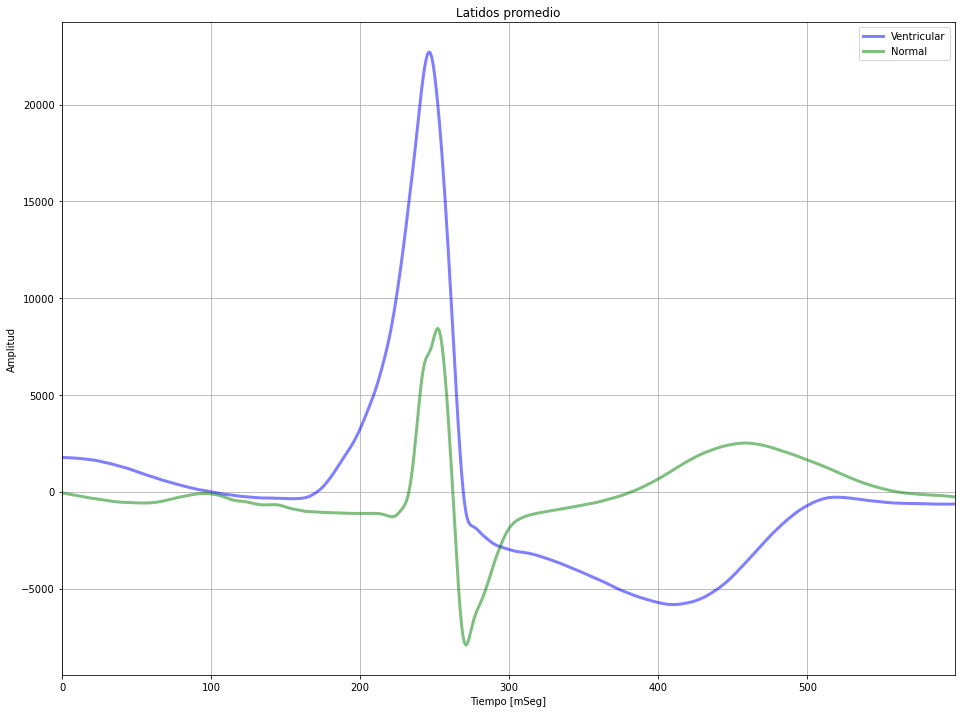

In [67]:

Ventricular = latidos[:,np.bitwise_not(filtro_normal)] 
Normal = latidos[:,filtro_normal]
plt.gcf().set_size_inches(16, 12)
plt.plot(Ventricular_promedio, 'b', label = 'Ventricular',alpha = 0.5, linewidth=3.0)
plt.plot(Normal_promedio, 'g', label = 'Normal', alpha = 0.5,  linewidth=3.0)
plt.legend()
plt.grid()
plt.title("Latidos promedio")
plt.xlabel('Tiempo [mSeg]')
plt.ylabel('Amplitud')
plt.autoscale(enable=True, axis='x', tight=True)

Asi podemos distinguir de manera más clara las diferentes características de cada tipo de señal.